### Set up notebook - imports and paths

In [2]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# matplotlib
import matplotlib.pyplot as plt

# cartopy
import cartopy.crs as ccrs

# extras
import geopandas as gpd
from rasterio.features import geometry_mask
import rioxarray
from shapely.geometry import mapping
from functools import reduce
# import odc.geo.xr
# import odc.geo.crs as odccrs
# from odc.geo.geobox import GeoBox

In [3]:
# Set up paths

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

## Import Data

### Read tARget v3 data

In [27]:
## Read data
path_to_data = '/work/dnash/data/'
filename =  'downloads/AR_catalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ar_filename = path_to_data + filename
ds = xr.open_dataset(ar_filename)
ds = ds.assign_coords({"lon": (((ds.lon + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
ds = ds.sortby(ds.lon)
test = ds.sel(time='2018-01-15 06:00', lev=1000., ens=1) # select a single time step from tARgetv3 data
test

<xarray.Dataset>
Dimensions:      (lon: 240, lat: 121)
Coordinates:
  * lon          (lon) float64 -180.0 -178.5 -177.0 -175.5 ... 175.5 177.0 178.5
  * lat          (lat) float64 -90.0 -88.5 -87.0 -85.5 ... 85.5 87.0 88.5 90.0
    lev          float64 1e+03
    time         datetime64[ns] 2018-01-15T06:00:00
    ens          float64 1.0
Data variables: (12/53)
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    shapemap     (lat, lon) float32 ...
    axismap      (lat, lon) float64 ...
    tnsctmap     (lat, lon) float64 ...
    lflocmap     (lat, lon) float32 ...
    ...           ...
    axisidx      (lat, lon) float32 ...
    axislon      (lat, lon) float32 ...
    axislat      (lat, lon) float32 ...
    xtnsctidx    (lat, lon) float32 ...
    numobj       (lat, lon) float32 ...
    intblosto    (lat, lon) float64 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.03.22
    creation_date:         22-Mar-2022 11:12:14
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

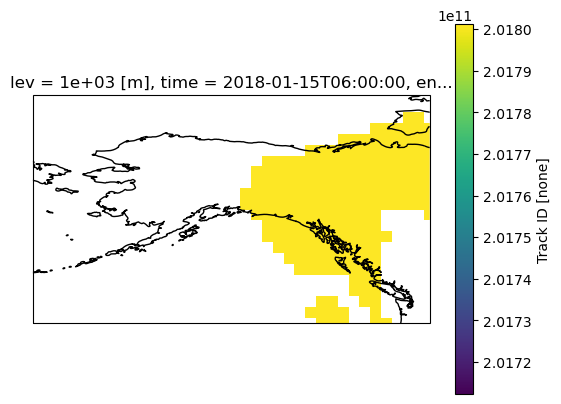

In [29]:
datacrs = ccrs.PlateCarree()
mapcrs = ccrs.PlateCarree()
varname = 'kidmap'
bnds = [-175, -120., 45., 75.] # extend of AK


p = test[varname].plot(x='lon', y='lat',
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},
)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines()
p.axes.set_extent(bnds)

### Open AK Shapefile Data

In [35]:
## use geopandas to import the watershed shapefile

fp = '/home/dnash/comet_data/downloads/AKregionOutline/AKregionOutline_wCAN.shp'
polys = gpd.read_file(fp, crs="epsg:3857") # have to manually set the projection
data = polys.iloc[0] # select that row from the dataframe
data # display

/home/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/pandas/core/dtypes/inference.py:387: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/home/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/pandas/core/dtypes/inference.py:388: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/home/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

STUSPS                                                       AK
Area_km2                                          1939244.98302
Shape_Leng                                        35002671.1036
Shape_Area                                      1939261153630.0
InPoly_FID                                                    1
SimPgnFlag                                                    0
MaxSimpTol                                                500.0
MinSimpTol                                                500.0
geometry      (POLYGON ((-549134.1206 516088.5080999993, -54...
Name: 0, dtype: object

## Play with plotting shapefile

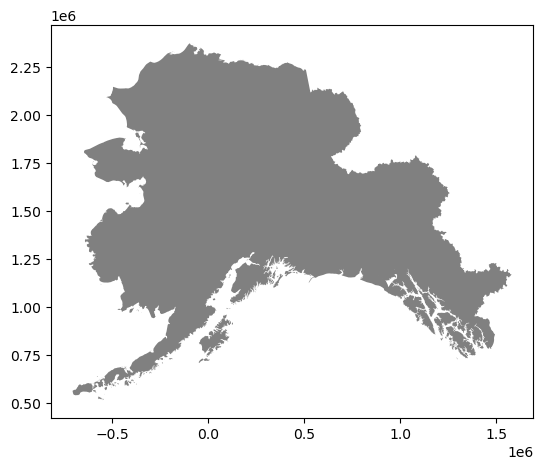

In [36]:
## plot single watershed highlighted
fig, ax = plt.subplots() # initiates a figure
polys.plot(ax=ax, facecolor='gray'); # plots all watersheds in grey
plt.tight_layout(); # cuts white space from fig

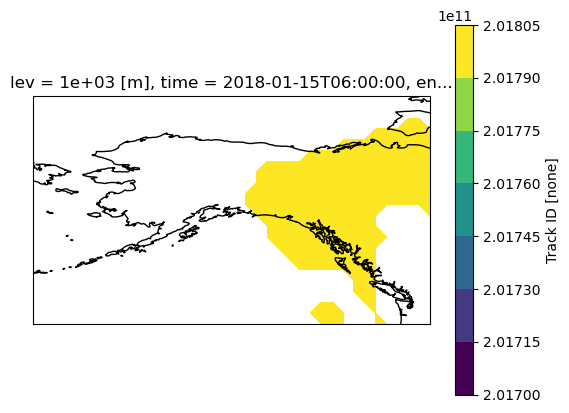

In [37]:
## now plot the single watershed on top of the WRF data

p = test[varname].plot.contourf(x='lon', y='lat', # creating a contour plot
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines() # add in coastlines so we know where we are
p.axes.set_extent(bnds)

polys.boundary.plot(ax=p.axes); # plot boundary of shapefile

## Crop WRF data to the shape of the watershed

In [12]:
ds = test # raster_mask
gdf = watershed # vector_mask

min_x, min_y, max_x, max_y = gdf.total_bounds
clipped  = ds.where((ds.lon<=max_x) & (ds.lon>=min_x) & (ds.lat<=max_y) & (ds.lat>=min_y), drop=True)

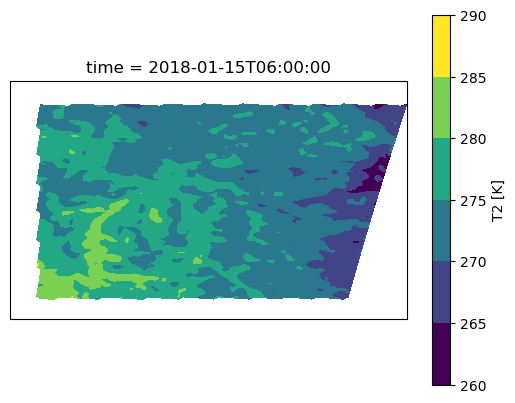

In [13]:
p = clipped[varname].plot.contourf(x='lon', y='lat', # creating a contour plot
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},)  # the plot's projection

In [15]:
ds = test # raster_mask
gdf = watershed # vector_mask

# we need to manually set the coordinate reference system because this data does not have it attached
ds.rio.write_grid_mapping(inplace=True)
ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
ds.rio.write_crs("epsg:4326", inplace=True) # manually setting the projection of the wrf data

clipped = ds.rio.clip(gdf.geometry.apply(mapping), ds.rio.crs, drop=False)
clipped = ds.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=False)

In [18]:
np.nanmax(clipped.T2.values)

/tmp/ipykernel_764/1821922989.py:1: RuntimeWarning: All-NaN slice encountered
  np.nanmax(clipped.T2.values)


nan

/cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


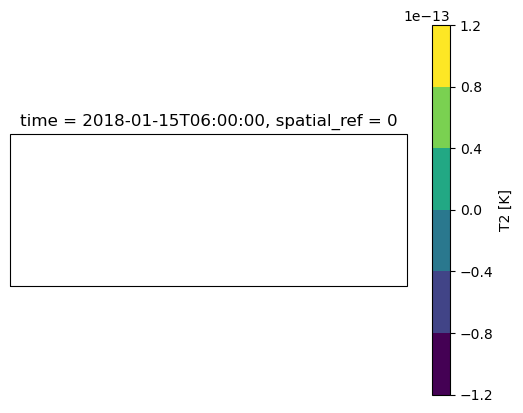

In [29]:
p = clipped[varname].plot.contourf(x='lon', y='lat', # creating a contour plot
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},)  # the plot's projection

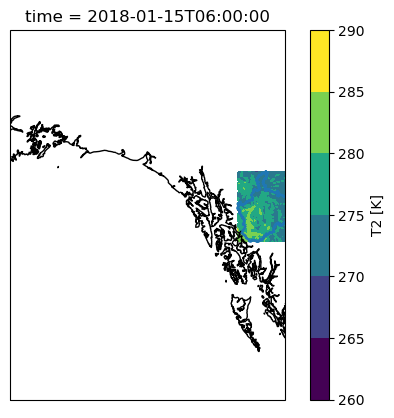

In [14]:
## plot masked WRF data
## overplot watershed too!
p = clipped[varname].plot.contourf(x='lon', y='lat', # creating a contour plot
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines() # add in coastlines so we know where we are
p.axes.set_extent([-150, -129, 50, 65])

watershed.boundary.plot(ax=p.axes); # plots only boundary of isolated watershed

In [17]:
## take the sum of the precipitation of the masked WRF data
test_sum = clipped[varname].sum(['y', 'x'])
test_sum.values
## note there wasn't any precipitation on this day within this watershed

array(0., dtype=float32)

## Make a function and iterate!

In [14]:
## write a function and then loop through the above sequence for each watershed

def clip_ds_shapefile(ds, gdf):
    """clip_ds_shapefile
    
    Returns a masked xarray ds object for the shape of the given watershed
    
    Parameters
    ----------
    ds : xarray dataset
    gdf : single geopandas object
  
    Returns
    -------
    ds : xarray dataset object
    
    """
    
    # we need to manually set the coordinate reference system because this data does not have it attached
    ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True) # manually setting the projection of the wrf data

    clipped = ds.rio.clip(gdf.geometry.apply(mapping), ds.rio.crs, drop=False)
    
    return clipped

In [15]:
%%time
object_lst = [4, 8, 10]

prec_lst = [] # make an empty list to append the data we want
for i, objectID in enumerate(object_lst): # iterate through the watersheds
    idx = polys['OBJECTID'] == objectID # get watershed with the objectID
    watershed = polys.loc[idx] # select that row from the dataframe
    
    watershedID = watershed.OBJECTID
    print('Processing watershed: ', objectID)
    clipped_ds = clip_ds_shapefile(wrf, watershed)
    
    var_sum = clipped_ds.sum(['lat', 'lon'])
    # convert the precipitation sum to a dataframe
    var_final = var_sum.prec.values
    var_lst.append(var_final)

Processing watershed:  4
Processing watershed:  8
Processing watershed:  10
CPU times: user 4min 54s, sys: 11min 55s, total: 16min 50s
Wall time: 11min 40s


In [16]:
## build a dictionary from our saved data
dicts = {}
keys = object_lst # column names
values = var_lst
for i, key in enumerate(keys):
        dicts[key] = values[i]

## put dictionary into single dataframe
df = pd.DataFrame(data=dicts)

df['time'] = wrf.time.values
df

,4,8,10,time
0,0.000000,0.0,0.0,1980-01-01 00:00:00
1,0.000000,0.0,0.0,1980-01-01 01:00:00
2,0.000000,0.0,0.0,1980-01-01 02:00:00
3,0.000000,0.0,0.0,1980-01-01 03:00:00
4,0.000000,0.0,0.0,1980-01-01 04:00:00
...,...,...,...,...
341635,3.515625,0.0,0.0,2018-12-31 19:00:00
341636,4.125000,0.0,0.0,2018-12-31 20:00:00
341637,5.007812,0.0,0.0,2018-12-31 21:00:00
341638,5.593750,0.0,0.0,2018-12-31 22:00:00


In [17]:
## save as csv file
## save to csv file
df.to_csv(path_to_out + 'watershed_{0}.csv'.format(varname))